0.0 Imports



In [1083]:
from IPython.display import Image
import pandas as pd
import numpy as np  
import seaborn as sns
from matplotlib import pyplot as plt


# 1.0 Business Understanding

### 1.1. Motivation/Problem (What is the probem? / Who is reporting the issue?)

In the US, Walmart has a system similar to Uber, where delivery drivers 
register to deliver orders placed through the Walmart website. 
These delivery drivers are not Walmart employees, but work independently, 
accepting delivery orders and receiving these orders from Walmart staff, 
then delivering them to the consumer's address. Many consumers have 
reported that certain items in their orders were not delivered, 
even though the system marked the delivery as complete. This raises some 
critical questions:

1. Delivery Driver Fraud: There is evidence that drivers may be reporting 
the delivery of items that did not actually reach the customer. 
They may be omitting or diverting items from the order, 
while still recording the delivery as complete.

2. System or Process Error: It may be that the problem lies in flaws in
the recording system or delivery process, not limited to intentional fraud.

3. Consumer Fraud: In some cases, consumers may claim they did not 
receive a product that was delivered in order to request a refund.

##### Walmart requested the data analyst to identify the potential causes of delivery-related fraud and propose a solution to prevent it.

### 1.2. Poblem Root Cause (Why a solution is requested?)

Customer satisfaction is decreasing due to missing items in completed deliveries.

Revenue losses are increasing due to customer refunds related to reported missing items.

### 1.3. Solution (How to solve the problem?):

Proceed with a descriptive analysis to identify risk patterns and anomalous behaviors, mainly concerning customers, drivers, and potential system errors, that may indicate fraudulent delivery activities.

Develop a fraud risk score framework to estimate the likelihood of risk in future deliveries.

### 1.4. Deliverable:

Presentation file including visualization charts and insights about the main causes of missing items in deliveries.

Interactive dashboard for delivery monitoring.

Fraud risk score framework to identify high-risk delivery patterns.

### 1.5. Tools:

Python: Exploratory Data Analysis and risk metric development.

Power BI: Interactive data visualization.

PowerPoint: Executive presentation of insights.


# 2.0 Data Understanding

The dataset is composed of five distinct tables, each operating at a different level of granularity. Understanding these differences is essential to avoid incorrect aggregations and misleading conclusions during the analysis.

### 2.1 Orders Table

The orders table represents delivery orders placed through Walmart’s e-commerce platform. Each row corresponds to a single order and contains information such as order value, delivery region, delivery time, and the number of items delivered and reported as missing.

It is important to note that the presence of missing items (items_missing > 0) does not confirm fraud, but rather indicates a reported delivery discrepancy.

### 2.2 Missing Items Data

The missing_items_data table contains information only about items reported by customers as not received. This table does not represent the full composition of an order, but only the subset of products that were declared missing.

As a result, this table should not be interpreted as a complete list of items per order, but rather as a complaint-level dataset.

### 2.3 Drivers Data

The drivers_data table provides demographic and operational information about delivery drivers, including age and total number of trips performed during the year. Each driver may be associated with multiple delivery orders.

### 2.4 Customers Data

The customers_data table contains demographic information about customers who placed orders. Similar to drivers, each customer may be associated with multiple orders over time.

### 2.5 Products Data

The products_data table includes information about individual products, such as category and price. Product-level analysis is only possible when this table is joined with the missing items data.

### 2.6 Absence of Fraud Labels

The dataset does not contain an explicit target variable indicating confirmed fraud. Consequently, the analysis cannot rely on supervised machine learning techniques and instead focuses on exploratory analysis, pattern detection, and risk assessment.


# 3.0 Solution Strategy

The solution strategy is diveded into two parts:

1. Exploratory Data Analysis - The objective is not to classify orders as fraudulent, but to prioritize investigations and preventive actions. Given the absence of confirmed fraud labels, the proposed approach focuses on identifying risk patterns and anomalous behaviors that may indicate higher likelihood of delivery-related issues.

2. Fraud risk score framework - The exploratory findings will serve as the foundation for the development of a Fraud Risk Score framework. This framework will aggregate relevant risk indicators identified during the analysis and assign a relative risk level to future delivery orders, supporting preventive monitoring and investigation prioritization.

### 3.1 Exploratory Data Analysis Methodology

The Fact-Dimension method is used to develop the data descriptive analysis.

#### 3.1.1 Main (Open) Question

How can delivery-related fraud risk be identified and reduced?

Are there observable patterns in delivery data that indicate higher risk of missing items?

#### 3.1.2 Closed Questions

Closed questions are structured, measurable questions that can be answered objectively using the available data. They guide the analytical process and support evidence-based conclusions.

They are divided into two categories:

##### 3.1.2.1 Impact-Level Questions

These questions quantify the magnitude and financial exposure of delivery discrepancies. They measure overall volume and economic impact, but do not identify behavioral concentration or disproportionate risk patterns by themselves.

##### 1. How manny items were not delivered? 

##### 2.What is the total revenue lost due to these undelivered items?

##### 3.1.2.2 Risk-Oriented Questions

These questions analyze proportional metrics across relevant dimensions in order to identify concentration effects, deviations from baseline behavior, and potential anomalous patterns that may indicate elevated delivery-related risk.

##### 3. Do certain drivers present disproportionately higher missing item rates compared to the overall average?

##### 4. Are missing item reports concentrated among a small subset of customers?

##### 5. Are specific product categories more frequently reported as missing?

##### 6. Do certain regions exhibit higher missing item rates?

##### 7. Is there a relationship between delivery time (hour) and missing item occurrences?

#### 3.1.3 Defining the fact table

order_id

items_missing

order_amount

items_delivered

revenue_lost (calculated)

#### 3.1.4 Defining Dimensions

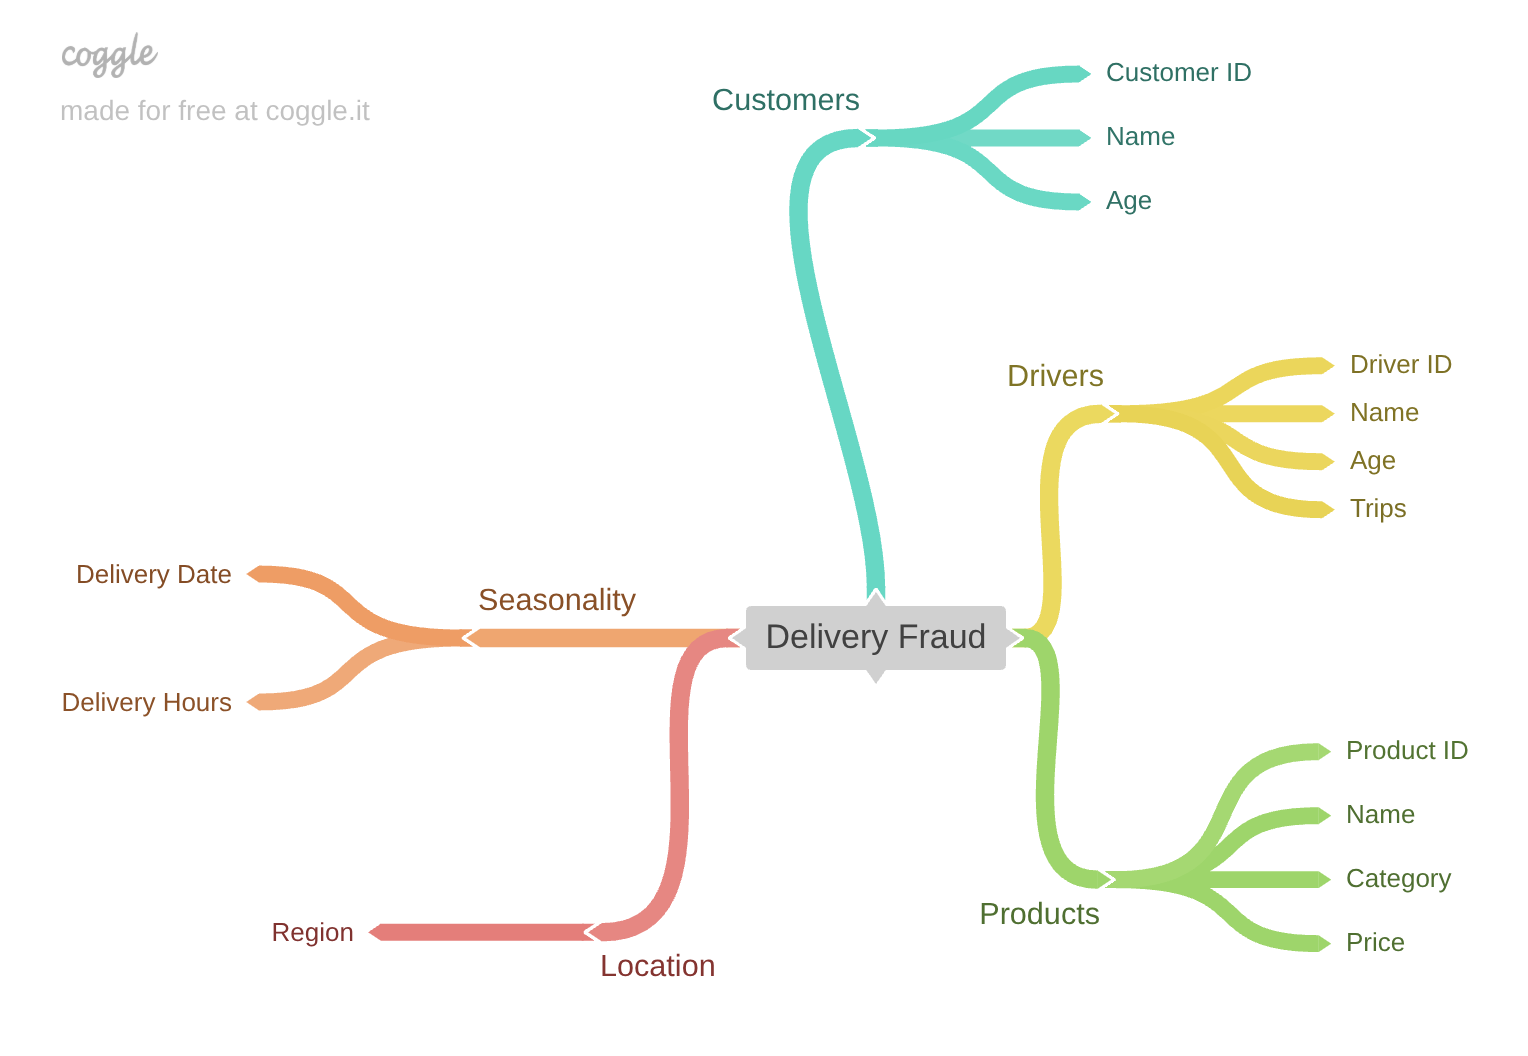

In [1084]:
Image('C:/Users/Igor/Repos/Walmart-Delivery-Fraud-Detection/images/delivery_fraud_dimensions.png')

### 3.2 Fraud Risk Score Framework Methodology

The Fraud Risk Score framework will be developed after identifying statistically and operationally relevant risk indicators during the exploratory analysis.

The framework will:

Select key risk variables derived from the EDA

Normalize and standardize relevant metrics

Combine weighted indicators into a composite risk score

Assign relative risk levels (e.g., low, medium, high) to delivery orders

The score will not represent confirmed fraud probability, but rather a relative risk assessment tool to support preventive decision-making.

4.0 Exploratory Data Analysis

perguntar se eh necessario incluir informacao sbre a Fraud risk score framework no solution strategy

### 0.1 Helper Functions

In [1085]:
def missing_values_summary(df, dataset_name=None):
    if dataset_name:
        print(f'\n=== Missing Values Summary: {dataset_name} ===')
    missing = (df.isna().sum().reset_index(name='missing_values'))
    missing['missing_%'] = missing['missing_values'] / len(df) * 100
    return missing.sort_values('missing_%', ascending=False)

#--/--

def check_unusual_values(df, 
                         numeric_cols=None, 
                         categorical_cols=None, 
                         id_cols=None,
                         sample=11):
    
    print('='*70)
    print('Checking Unusual / Incoherent Values')
    print('='*70)
    
    
    # ========================
    # Numerical Checks
    # ========================
    
    if numeric_cols:
        print('\n Numerical Columns:\n')
        
        for col in numeric_cols:
            
            if df[col].dtype.kind in 'biufc':
                sorted_values = np.sort(df[col].dropna().values)
            
            # Convert numpy types to Python native types
            sorted_values = [v.item() if hasattr(v, 'item') else v 
                             for v in sorted_values]
            
            if len(sorted_values) > sample * 2:
                preview = (
                    sorted_values[:sample] +
                    ['...'] +
                    sorted_values[-sample:]
                )
            else:
                preview = sorted_values
            
            negative_count = (df[col] < 0).sum()
            
            print(f'Column: {col}')
            print(f'Negative / Non-Numeroic values count: {negative_count}')
            print(f'Sample values: {preview}\n')
    
    
    # ========================
    # ID duplicate checks
    # ========================
    
    if id_cols:
        print('\n Duplicate Checks:\n')
        
        for col in id_cols:
            dup_count = df[col].duplicated().sum()
            dup_len = df[col].nunique() == len(df)
            print(f'Column: {col} → Duplicated values: {dup_count} → Unique values match total rows: {dup_len}')
    
    
    # ========================
    # Categorical Checks
    # ========================
    
    if categorical_cols:
        print('\n Categorical Columns:\n')
        
        for col in categorical_cols:
            
            unique_vals = df[col].dropna().unique()
            preview = sorted(unique_vals[:sample])
            
            # Convert numpy/object types
            unique_vals = [v.item() if hasattr(v, 'item') else v 
                           for v in unique_vals]
            
            if len(unique_vals) > sample:
                preview = unique_vals[:sample] + ['...']
            else:
                preview = unique_vals
            
            print(f'Column: {col}')
            print(f'Unique values sample: {preview}\n')

    return

#--/--

def variables_summary(df, dataset_name=None):
    
    print('='*70)
    if dataset_name:
        print(f'Dataset - {dataset_name}')
    print('='*70)
    
    # =============================
    # Numerical Variables
    # =============================
    
    num = df.select_dtypes(include=['int64', 'float64'])
    
    if not num.empty:
        
        # IQR for outliers
        Q1 = num.quantile(0.25)
        Q3 = num.quantile(0.75)
        IQR = Q3 - Q1
        
        outliers = ((num < (Q1 - 1.5 * IQR)) | 
                    (num > (Q3 + 1.5 * IQR))).sum()
        
        num_summary = num.agg(['min','max','mean','median','std','skew','kurt']).T
        num_summary['range'] = num_summary['max'] - num_summary['min']
        num_summary['outliers_count'] = outliers
        num_summary = num_summary.reset_index().rename(columns={'index':'attribute'})

        # Reorder columns
        num_summary = num_summary[
            ['attribute', 'min', 'max', 'range',
            'mean', 'median', 'std', 'skew', 'kurt',
            'outliers_count']]
        
        print('\n Numerical Summary:\n')
        display(num_summary)
    
    # =============================
    # Categorical Variables
    # =============================
    
    cat = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])
    
    if not cat.empty:
        
        cat_summary = pd.DataFrame({
            'attribute': cat.columns,
            'unique_values': cat.nunique().values,
            'most_frequent': cat.mode().iloc[0].values,
            'frequency': [
                cat[col].value_counts().iloc[0]
                for col in cat.columns
            ]
        })
        
        print('\n Categorical Summary:\n')
        display(cat_summary)
    
    return

def variables_summary_plots(df):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    for col in numeric_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Histogram
        sns.histplot(df[col], kde=True, ax=axes[0])
        axes[0].set_title(f'Histogram - {col}')

        # Boxplot
        sns.boxplot(x=df[col], ax=axes[1])
        axes[1].set_title(f'Boxplot - {col}')

        plt.tight_layout()
        plt.show()

    return

#--/--

def export_eda_to_excel(file_name, missing=None, num_summary=None, cat_summary=None):
    
    with pd.ExcelWriter(file_name) as writer:
        
        if missing is not None and not missing.empty:
            missing.to_excel(writer, sheet_name='Missing', index=False)
            
        if num_summary is not None and not num_summary.empty:
            num_summary.to_excel(writer, sheet_name='Numerical', index=False)
            
        if cat_summary is not None:
            cat_summary.to_excel(writer, sheet_name='Categorical', index=False)
    
    print(f'\n Report exported to {file_name}')

# 4.0 Loading Data

In [1086]:
data_path = 'C:/Users/Igor/Repos/Walmart-Delivery-Fraud-Detection/datasets/'

df_orders_raw = pd.read_csv (data_path + 'orders.csv', low_memory=False)
df_missing_items_raw = pd.read_csv (data_path + 'missing_items_data.csv', low_memory=False)
df_products_raw = pd.read_csv (data_path + 'products_data.csv', low_memory=False)
df_customers_raw = pd.read_csv (data_path + 'customers_data.csv', low_memory=False)
df_drivers_raw = pd.read_csv (data_path + 'drivers_data.csv', low_memory=False)


In [1087]:
df_orders_raw.sample()

,date,order_id,order_amount,region,items_delivered,items_missing,delivery_hour,driver_id,customer_id
3140,27/04/2023,b72e9cef-6337-48f8-a08b-e2e61bb7eb8d,$400.16,Winter Park,17,0,03:35:21,WDID10554,WCID5355


In [1088]:
df_missing_items_raw.sample()

,order_id,product_id_1,product_id_2,product_id_3
1431,643fc0aa-d545-4317-9b72-e0fdfcd28a42,PWPX0982761091122,NaN,NaN


In [1089]:
df_products_raw.sample()

,produc_id,product_name,category,price
5,PWPX0982761091050,Rice Pudding,Supermarket,$10.16


In [1090]:
df_customers_raw.sample()

,customer_id,customer_name,customer_age
548,WCID5467,Leah James,25


In [1091]:
df_drivers_raw.sample()

,driver_id,driver_name,age,Trips
49,WDID10083,Andrea Choi,19,28


# 4.0 Data Description

In [1092]:
df_orders_1 = df_orders_raw.copy()
df_missing_items_1 = df_missing_items_raw.copy()
df_products_1 = df_products_raw.copy()
df_customers_1 = df_customers_raw.copy()
df_drivers_1 = df_drivers_raw.copy()

## 4.1 Columns Rename

In [1093]:
df_orders_1.columns

Index(['date', 'order_id', 'order_amount', 'region', 'items_delivered',
       'items_missing', 'delivery_hour', 'driver_id', 'customer_id'],
      dtype='object')

In [1094]:
df_missing_items_1.columns

Index(['order_id', 'product_id_1', 'product_id_2', 'product_id_3'], dtype='object')

In [1095]:
df_products_1.columns

Index(['produc_id', 'product_name', 'category', 'price'], dtype='object')

In [1096]:
df_customers_1.columns

Index(['customer_id', 'customer_name', 'customer_age'], dtype='object')

In [1097]:
df_drivers_1.columns

Index(['driver_id', 'driver_name', 'age', 'Trips'], dtype='object')

In [1098]:
# The columns 'produc_id', 'category', 'price', 'age' and 'Trips' from datasets df_products_1 and df_drivers_1 need to be renamed.

df_products_1 = df_products_1.rename(columns={'produc_id': 'product_id', 'category': 'product_category', 'price': 'product_price'})
df_drivers_1 = df_drivers_1.rename(columns={'age': 'driver_age', 'Trips': 'driver_trips'})

In [1099]:
df_products_1.columns

Index(['product_id', 'product_name', 'product_category', 'product_price'], dtype='object')

In [1100]:
df_drivers_1.columns

Index(['driver_id', 'driver_name', 'driver_age', 'driver_trips'], dtype='object')

## 4.2 Data Dimensions

In [1101]:
# Orders DataFrame

print( 'Number of Rows: {}'.format( df_orders_1.shape[0] ))
print( 'Number of Columns: {}'.format( df_orders_1.shape[1] ))

Number of Rows: 10000
Number of Columns: 9


In [1102]:
# Missing Items DataFrame

print( 'Number of Rows: {}'.format( df_missing_items_1.shape[0] ))
print( 'Number of Columns: {}'.format( df_missing_items_1.shape[1] ))

Number of Rows: 1502
Number of Columns: 4


In [1103]:
# Products DataFrame

print( 'Number of Rows: {}'.format( df_products_1.shape[0] ))
print( 'Number of Columns: {}'.format( df_products_1.shape[1] ))

Number of Rows: 314
Number of Columns: 4


In [1104]:
# Customers DataFrame

print( 'Number of Rows: {}'.format( df_customers_1.shape[0] ))
print( 'Number of Columns: {}'.format( df_customers_1.shape[1] ))

Number of Rows: 1239
Number of Columns: 3


In [1105]:
# Drivers DataFrame

print( 'Number of Rows: {}'.format( df_drivers_1.shape[0] ))
print( 'Number of Columns: {}'.format( df_drivers_1.shape[1] ))

Number of Rows: 1247
Number of Columns: 4


## 4.3 Data Types

In [1106]:
 # Orders DataFrame

# Before to update the column order_amount from object to float, it is necessary to remove the dollar sign $.
df_orders_1['order_amount'] = (df_orders_1['order_amount'].str.replace('$', '', regex=False).str.replace(',', '', regex=False))

# Updating the colums type.
df_orders_1['date'] = pd.to_datetime( df_orders_1['date'].str.replace( '-' , '/' ), dayfirst=True, errors = 'coerce' )
df_orders_1['delivery_hour'] = pd.to_timedelta(df_orders_1['delivery_hour'], errors='coerce')
df_orders_1['order_amount'] = df_orders_1['order_amount'].astype('float64')
df_orders_1['items_delivered'] = df_orders_1['items_delivered'].astype('int64')
df_orders_1['items_missing'] = df_orders_1['items_missing'].astype('int64')

In [1107]:
df_orders_1.dtypes

date                datetime64[ns]
order_id                    object
order_amount               float64
region                      object
items_delivered              int64
items_missing                int64
delivery_hour      timedelta64[ns]
driver_id                   object
customer_id                 object
dtype: object

In [1108]:
df_orders_1.head()

,date,order_id,order_amount,region,items_delivered,items_missing,delivery_hour,driver_id,customer_id
0,2023-01-01,c9da15aa-be24-4871-92a3-dfa7746fff69,1095.54,Winter Park,10,1,0 days 08:37:28,WDID10627,WCID5031
1,2023-01-01,ccacc183-09f8-4fd5-af35-009d18656326,659.11,Altamonte Springs,11,1,0 days 09:31:17,WDID10533,WCID5794
2,2023-01-01,f4e1d30b-c3d1-413f-99b8-93c0b46d68bf,251.45,Winter Park,18,1,0 days 10:43:49,WDID10559,WCID5599
3,2023-01-01,993d31f4-9358-41f0-a371-0021e55cef5d,598.83,Altamonte Springs,12,1,0 days 09:48:33,WDID10622,WCID5005
4,2023-01-01,3e0a8f1b-3cd6-4d64-90e3-6b38dc368925,27.18,Clermont,3,1,0 days 10:09:49,WDID10654,WCID5114


In [1109]:
# Missing Items DataFrame

df_missing_items_1.dtypes

# Not necessary to update the columns types.

order_id        object
product_id_1    object
product_id_2    object
product_id_3    object
dtype: object

In [1110]:
# Products DataFrame

# Before to update the column product_price from object to float, it is necessary to remove the dollar sign $.
df_products_1['product_price'] = (df_products_1['product_price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False))

# Updating the colums type.
df_products_1['product_price'] = df_products_1['product_price'].astype('float64')

In [1111]:
df_products_1.dtypes

product_id           object
product_name         object
product_category     object
product_price       float64
dtype: object

In [1112]:
# Customers DataFrame

df_customers_1.dtypes

# Not necessary to update the columns types.

customer_id      object
customer_name    object
customer_age      int64
dtype: object

In [1113]:
# Drivers DataFrame

df_drivers_1.dtypes

# Not necessary to update the columns types.

driver_id       object
driver_name     object
driver_age       int64
driver_trips     int64
dtype: object

### 4.4 Check NA

In [1114]:
# Orders Dataset
 
missing_values_summary(df_orders_1, 'Orders')


=== Missing Values Summary: Orders ===


,index,missing_values,missing_%
0,date,0,0.0
1,order_id,0,0.0
2,order_amount,0,0.0
3,region,0,0.0
4,items_delivered,0,0.0
5,items_missing,0,0.0
6,delivery_hour,0,0.0
7,driver_id,0,0.0
8,customer_id,0,0.0


No missing values.

In [1115]:
# Missing Items Dataset

missing_values_summary(df_missing_items_1, 'Missing Items')


=== Missing Values Summary: Missing Items ===


,index,missing_values,missing_%
3,product_id_3,1484,98.801598
2,product_id_2,1359,90.479361
1,product_id_1,0,0.000000
0,order_id,0,0.000000


Missing values are expected because this dataframe lists the quantity of products not delivered, which variate between 1 to 3.

The columns product_id_1 2 and 3 lists the product id that was no delivered, if column product_id_2 and product_id_3 are set as NA, means that only one product is missing.

If only product_id_3 is set as NA, means that 2 products are missing.

If all products Ids columns have the Ids listed, means that 3 products are missing.

In [1116]:
# Products Dataset

missing_values_summary(df_products_1, 'Products')


=== Missing Values Summary: Products ===


,index,missing_values,missing_%
0,product_id,0,0.0
1,product_name,0,0.0
2,product_category,0,0.0
3,product_price,0,0.0


 No Missing values

In [1117]:
# Customers DataFrame

missing_values_summary(df_customers_1, 'Customers')


=== Missing Values Summary: Customers ===


,index,missing_values,missing_%
0,customer_id,0,0.0
1,customer_name,0,0.0
2,customer_age,0,0.0


 No Missing values

In [1118]:
# Drivers Dataset

missing_values_summary(df_drivers_1, 'Drivers')


=== Missing Values Summary: Drivers ===


,index,missing_values,missing_%
0,driver_id,0,0.0
1,driver_name,0,0.0
2,driver_age,0,0.0
3,driver_trips,0,0.0


 No Missing values

### 4.5 Check Unusual/Incoherent Values

In [1119]:
# Orders Dataset

check_unusual_values( df_orders_1, numeric_cols=['order_amount', 'items_delivered', 'items_missing'], categorical_cols=['region'], id_cols=['order_id'])

Checking Unusual / Incoherent Values

 Numerical Columns:

Column: order_amount
Negative / Non-Numeroic values count: 0
Sample values: [20.08, 20.17, 20.17, 20.37, 20.41, 20.44, 20.45, 20.45, 20.46, 20.54, 20.61, '...', 1277.35, 1279.02, 1285.46, 1286.42, 1297.08, 1324.41, 1324.96, 1330.65, 1354.71, 1379.81, 1386.0]

Column: items_delivered
Negative / Non-Numeroic values count: 0
Sample values: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '...', 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]

Column: items_missing
Negative / Non-Numeroic values count: 0
Sample values: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '...', 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


 Duplicate Checks:

Column: order_id → Duplicated values: 0 → Unique values match total rows: True

 Categorical Columns:

Column: region
Unique values sample: ['Winter Park', 'Altamonte Springs', 'Clermont', 'Sanford', 'Apopka', 'Kissimmee', 'Orlando']



In [1121]:
check_unusual_values( df_orders_1, numeric_cols=['order_amount', 'items_delivered', 'items_missing'], categorical_cols=['region'], id_cols=['order_id'])

Checking Unusual / Incoherent Values

 Numerical Columns:

Column: order_amount
Negative / Non-Numeroic values count: 0
Sample values: [20.08, 20.17, 20.17, 20.37, 20.41, 20.44, 20.45, 20.45, 20.46, 20.54, 20.61, '...', 1277.35, 1279.02, 1285.46, 1286.42, 1297.08, 1324.41, 1324.96, 1330.65, 1354.71, 1379.81, 1386.0]

Column: items_delivered
Negative / Non-Numeroic values count: 0
Sample values: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '...', 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]

Column: items_missing
Negative / Non-Numeroic values count: 0
Sample values: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '...', 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


 Duplicate Checks:

Column: order_id → Duplicated values: 0 → Unique values match total rows: True

 Categorical Columns:

Column: region
Unique values sample: ['Winter Park', 'Altamonte Springs', 'Clermont', 'Sanford', 'Apopka', 'Kissimmee', 'Orlando']



In [1124]:
# Missing Items Dataset

check_unusual_values( df_missing_items_1, id_cols=['order_id', 'product_id_1', 'product_id_2', 'product_id_3'])

Checking Unusual / Incoherent Values

 Duplicate Checks:

Column: order_id → Duplicated values: 0 → Unique values match total rows: True
Column: product_id_1 → Duplicated values: 1357 → Unique values match total rows: False
Column: product_id_2 → Duplicated values: 1398 → Unique values match total rows: False
Column: product_id_3 → Duplicated values: 1483 → Unique values match total rows: False


Duplicates on columns 'product_id_1', 'product_id_2', 'product_id_3' are expected.

In [1125]:
# Products Dataset

check_unusual_values( df_products_1, numeric_cols=['product_price'], categorical_cols=['product_category'], id_cols=['product_id', 'product_name'])

Checking Unusual / Incoherent Values

 Numerical Columns:

Column: product_price
Negative / Non-Numeroic values count: 0
Sample values: [2.07, 2.08, 2.16, 2.21, 2.21, 2.31, 2.48, 2.62, 2.64, 2.65, 2.72, '...', 647.73, 690.88, 710.27, 725.5, 738.81, 750.72, 783.07, 808.21, 840.38, 880.38, 908.87]


 Duplicate Checks:

Column: product_id → Duplicated values: 0 → Unique values match total rows: True
Column: product_name → Duplicated values: 0 → Unique values match total rows: True

 Categorical Columns:

Column: product_category
Unique values sample: ['Supermarket', 'Bakery', 'Frozen', 'Beverages', 'Pantry', 'Dairy', 'Household', 'Snacks', 'Personal Care', 'Produce', 'Electronics']



In [1126]:
# Customers Dataset

check_unusual_values( df_customers_1, numeric_cols=['customer_age'], id_cols=['customer_id', 'customer_name'])

Checking Unusual / Incoherent Values

 Numerical Columns:

Column: customer_age
Negative / Non-Numeroic values count: 0
Sample values: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, '...', 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]


 Duplicate Checks:

Column: customer_id → Duplicated values: 0 → Unique values match total rows: True
Column: customer_name → Duplicated values: 9 → Unique values match total rows: False


In [1127]:
# Customers with duplicated names and ages.

# df_customers_1[df_customers_1.duplicated(subset=['customer_name', 'customer_age'], keep=False)].sort_values(['customer_name', 'customer_age'])
# df_customers_1['customer_name'].value_counts()[lambda x: x > 1]

df_customers_1.groupby(['customer_name', 'customer_age']).size().reset_index(name='count')
df_customers_1.groupby(['customer_name', 'customer_age']).size() \
    .reset_index(name='count') \
    .query('count > 1')

,customer_name,customer_age,count


Despite there are duplicated customer names, they are not duplicated customer_id or customer_age, which means that they are different customers with the same name. Therefore, there is no inconsistency in the dataset.

In [1128]:
# Drivers Dataset

check_unusual_values( df_drivers_1, numeric_cols=['driver_age', 'driver_trips'], id_cols=['driver_id', 'driver_name'])

Checking Unusual / Incoherent Values

 Numerical Columns:

Column: driver_age
Negative / Non-Numeroic values count: 0
Sample values: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, '...', 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65]

Column: driver_trips
Negative / Non-Numeroic values count: 0
Sample values: [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, '...', 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78]


 Duplicate Checks:

Column: driver_id → Duplicated values: 0 → Unique values match total rows: True
Column: driver_name → Duplicated values: 18 → Unique values match total rows: False


In [1129]:
# Drivers with duplicated names and ages.

# df_drivers_1[df_drivers_1.duplicated(subset=['driver_name', 'driver_age'], keep=False)].sort_values(['driver_name', 'driver_age'])

df_drivers_1.groupby(['driver_name', 'driver_age']).size().reset_index(name='count')
df_drivers_1.groupby(['driver_name', 'driver_age']).size() \
    .reset_index(name='count') \
    .query('count > 1')

,driver_name,driver_age,count
167,Brittany Morgan,19,2
295,Daniel Hall,20,2
945,Patricia Vance,18,2
1165,Timothy Brown,37,2


These duplicated driver names and ages could be the same person, but with different driver_id, which could be a indication of fraudulent activity, 
such as a driver using multiple identities to steal deliveries and earn more money.

Necessary to investigate further these duplicated driver names and ages, by checking if they have missing items on the orders they were responsible for.

# 5.0 Descriptive Statistical

## 5.1 Orders Dataset

In [1130]:
df_orders_2 = df_orders_1.copy()
df_missing_items_2 = df_missing_items_1.copy()
df_products_2 = df_products_1.copy()
df_customers_2 = df_customers_1.copy()
df_drivers_2 = df_drivers_1.copy()

In [1131]:
# Central Tendecy
# Definition: resume os dados em um unico numero.
# Metrics: mean , median

# Dispersion
# Definition: Dizem se os dados estao muito concentrados perto da media/mediana ou se os dados estao muito dispersos da media/mediana
# Metrics: std, min, max, range, skew (como eh a deformacao dos dados em relacao a distribuicao normal (forma de sino). Para e esquerda a skem eh positiva, para direite negativa), 
# kurtosis (fala sobre a concentracao dos dados. Quanto maior a kurtose positiva, mais dados concentrados com pico muito alto. Quanto menor a kurtose negativa,
# tem-se pico menor e valores mais dispersos).

Dataset - Orders

 Numerical Summary:



,attribute,min,max,range,mean,median,std,skew,kurt,outliers_count
0,order_amount,20.08,1386.0,1365.92,283.302238,270.535,181.681638,1.547763,5.263344,240
1,items_delivered,1.00,19.0,18.00,9.969400,10.000,5.459693,0.011747,-1.200285,0
2,items_missing,0.00,3.0,3.00,0.165700,0.000,0.414320,2.576987,6.923017,1502



 Categorical Summary:



,attribute,unique_values,most_frequent,frequency
0,order_id,10000,00005d78-6f97-4699-a746-19826f415e38,1
1,region,7,Winter Park,1485
2,delivery_hour,9404,0 days 00:19:23,4
3,driver_id,1247,WDID09873,11
4,customer_id,1239,WCID6096,19


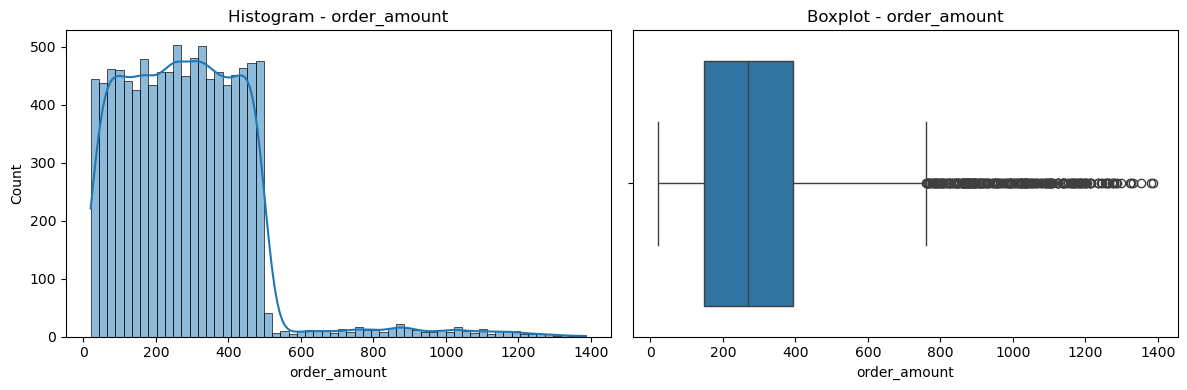

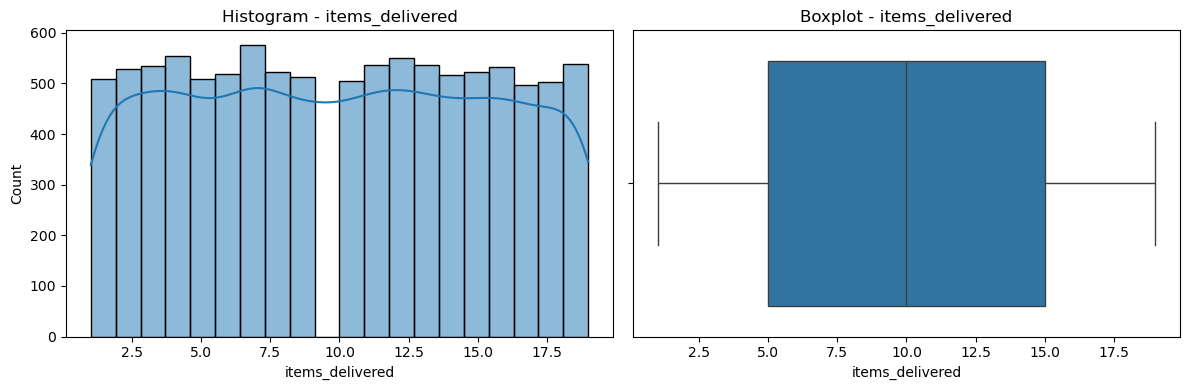

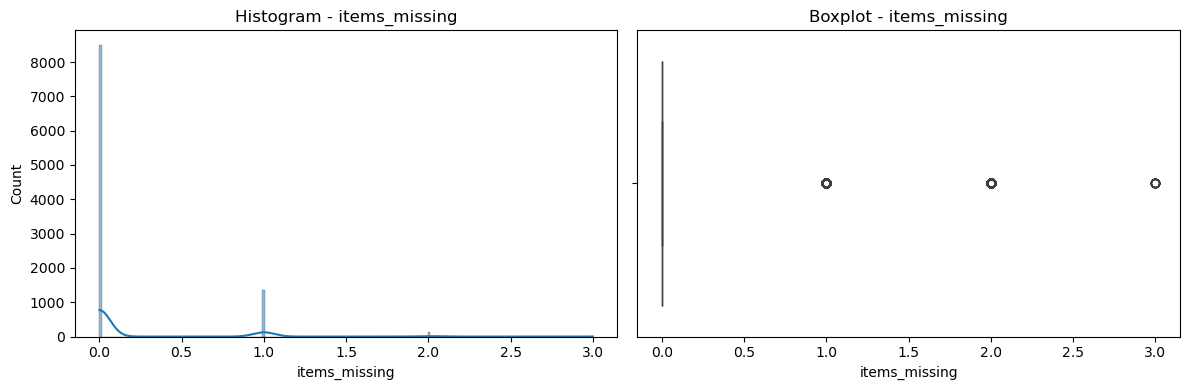

In [1132]:
variables_summary(df_orders_2, dataset_name='Orders')
variables_summary_plots(df_orders_2)

### Numerical Attributes:

#### Order_amount

Mean and Median: Values are relatively close, indicating a centered distribution. The distribution is right-skewed (positive skew), meaning a few high-value orders stretch the tail toward larger amounts.

Skew: Positive, the tail extends toward higher values, while most orders are concentrated between $0 and $500.

Kurtosis: High, leptokurtic distribution, with a sharp central peak and data tightly concentrated around the mean.

#### Items_delivered

Mean and Median: Similar values, indicating a uniform distribution. The frequencies of different quantities delivered are approximately equal.

Skew: Close to 0, symmetric distribution.

Kurtosis: Negative, platykurtic distribution, with more dispersed values and no strong concentration around the mean.

#### Items_missing

Mean and Median: Multimodal distribution, with approximately four decreasing peaks as the number of missing items increases.

Skew: Highly positive, most data are near 0, with few higher values.

Kurtosis: High, leptokurtic distribution, concentrating many observations at 0.

Outliers: Values 1, 2, and 3 could be considered statistical outliers, but they will not be treated as such since this attribute is the fact table used for identifying fraud risk.

## 5.2 Missing Items Dataset

In [1133]:
variables_summary(df_missing_items_2, dataset_name='Missing Items')
variables_summary_plots(df_missing_items_2)

Dataset - Missing Items

 Categorical Summary:



,attribute,unique_values,most_frequent,frequency
0,order_id,1502,000e50be-92e8-46dc-9ff8-91a955b47ab7,1
1,product_id_1,145,PWPX0982761090993,16
2,product_id_2,103,PWPX0982761090982,2
3,product_id_3,18,PWPX0982761090982,1


## 5.3 Products Dataset

Dataset - Products

 Numerical Summary:



,attribute,min,max,range,mean,median,std,skew,kurt,outliers_count
0,product_price,2.07,908.87,906.8,59.129936,11.275,164.990844,3.608371,12.285708,30



 Categorical Summary:



,attribute,unique_values,most_frequent,frequency
0,product_id,314,PWPX0982761090982,1
1,product_name,314,7 Up,1
2,product_category,11,Supermarket,115


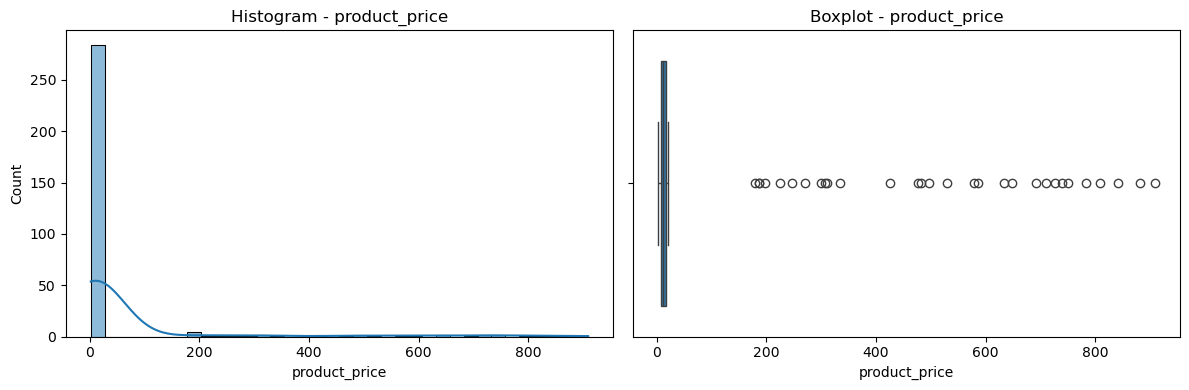

In [1134]:
# spliting numerical columns from categorical columns

variables_summary(df_products_2, dataset_name='Products')
variables_summary_plots(df_products_2)

### Numerical Attributes:

#### Product_price

Mean and Median: The mean and median are relatively close, but the distribution is slightly right-skewed, meaning most values are concentrated toward the lower end.

Skew: Positive, indicating a tail extending toward higher prices. Most values are clustered between $0 and $200.

Kurtosis: High, suggesting a leptokurtic distribution with a sharp peak, meaning the data are tightly concentrated. According to the histogram and skew, most prices are between $0 and $200.

## 5.4 Customers Dataset

Dataset - Customers

 Numerical Summary:



,attribute,min,max,range,mean,median,std,skew,kurt,outliers_count
0,customer_age,18.0,90.0,72.0,54.421308,55.0,20.911501,-0.030328,-1.190029,0



 Categorical Summary:



,attribute,unique_values,most_frequent,frequency
0,customer_id,1239,WCID5000,1
1,customer_name,1230,Angela Smith,2


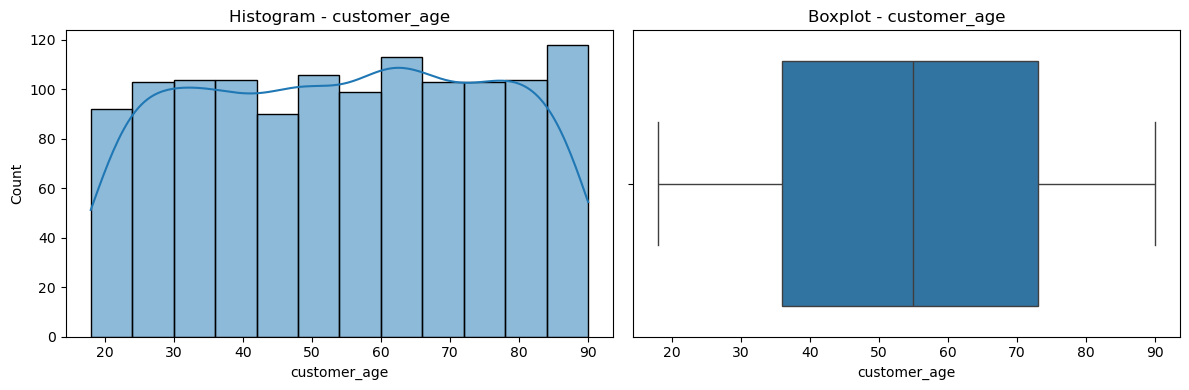

In [1135]:
variables_summary(df_customers_2, dataset_name='Customers')
variables_summary_plots(df_customers_2)

### Numerical Attributes:

#### Customer_age

Mean and Median: The mean and median are relatively close, and the frequency of values is fairly uniform. The histogram bars have approximately equal heights, indicating a uniform distribution.

Skew: Close to zero, showing that the distribution is symmetric, with data roughly equally distributed on both sides of the mean.

Kurtosis: Negative, indicating a platykurtic distribution, meaning the data are more dispersed and not concentrated around a single value.

## 5.5 Drivers Dataset

Dataset - Drivers

 Numerical Summary:



,attribute,min,max,range,mean,median,std,skew,kurt,outliers_count
0,driver_age,18.0,65.0,47.0,34.170810,30.0,15.441928,0.547450,-1.137527,0
1,driver_trips,11.0,78.0,67.0,45.665597,46.0,19.747758,-0.049342,-1.203175,0



 Categorical Summary:



,attribute,unique_values,most_frequent,frequency
0,driver_id,1247,WDID09872,1
1,driver_name,1229,Ashley Brown,2


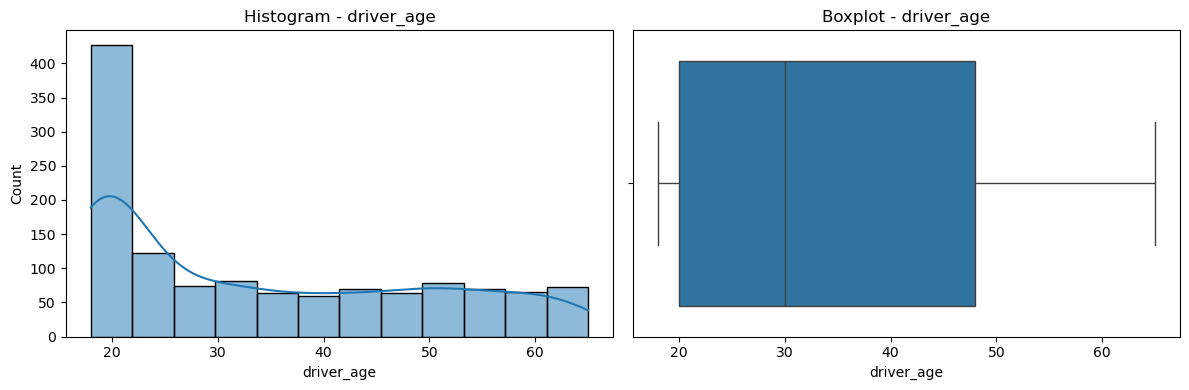

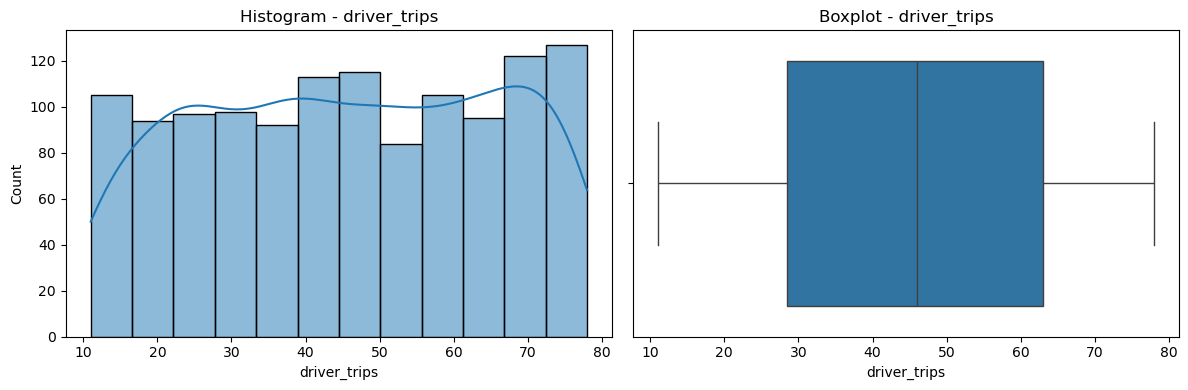

In [1136]:
variables_summary(df_drivers_2, dataset_name='Drivers')
variables_summary_plots(df_drivers_2)

### Numerical Attributes:

#### Driver_age

Mean and Median: Values are fairly uniformly distributed, with histogram bars of similar height, although there is a concentration of data between 20 and 23 years.

Skew: Close to zero, showing a symmetric distribution, despite the accumulation of drivers aged 20–23.

Kurtosis: Negative, suggesting a platykurtic distribution, with values well dispersed and no extreme concentration, although the peak around 20–23 years is noticeable.

#### Driver_trips

Mean and Median: Values are fairly uniform, with histogram bars of roughly equal height, indicating a uniform distribution.

Skew: Close to zero, showing a symmetric distribution, with roughly equal values on both sides of the mean.

Kurtosis: Negative, indicating a platykurtic distribution, with data spread evenly and no strong concentration around a specific value.



# 6.0 Data Featuring

In [1137]:
print(df_products_1['product_category'].value_counts(), end='\n\n')

product_category
Supermarket      115
Electronics       30
Bakery            22
Snacks            21
Household         21
Dairy             20
Pantry            19
Frozen            18
Produce           18
Beverages         17
Personal Care     13
Name: count, dtype: int64



Aside the Eletronics, all other categories are sub-categories from the macro category Supermaket. 
Therefore, a category called 'macro_category' will be createed to separate eletronics from groceries.

In [1138]:
# Creating macro category column

df_products_1['macro_category'] = df_products_1['product_category'].apply(
    lambda x: 'Electronics' if x == 'Electronics' else 'Supermarket' )

# Moving the column 'macro_category' to the penultimate position.

#  Remove the column from the end
col = df_products_1.pop('macro_category')

# 2. Insert the column in the desired position (penultimate).
df_products_1.insert(len(df_products_1.columns)-1, 'macro_category', col)

In order to know which sub-categories are significant for the analysis, it is necessary to verify the missing items per sub-category.

In [1139]:
# First, it is necessary to merge the orders dataframe with the missing items dataframe, because the missing items dataframe has the product_id of the products that were not delivered,
#  and this information is necessary to merge with the products dataframe to get the product category and price information.

# Merging df_orders_2 with df_missing_items_2 to get the product_id of the products that were not delivered.
df = pd.merge(df_orders_2, df_missing_items_2, on='order_id', how='left')

# Second, it is necessary to merge the resulting dataframe with the products dataframe to get the product category and price information.

# 🔹 Merging all columns from df_products_1
for i in [1, 2, 3]:
    df = df.merge(
        df_products_1.add_suffix(f'_{i}'),
        left_on=f'product_id_{i}',
        right_on=f'product_id_{i}',
        how='left'
    )

# 🔹 Filling NANs.
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(0)
    else:
        df[col] = df[col].fillna('None')

# Reorganizing colmuns.

def move_columns_after(df, move_map):
    """
    move_map: dicionário {coluna_a_mover: coluna_destino}
    Move cada coluna_a_mover para ficar logo após coluna_destino
    """
    cols = list(df.columns)
    
    for col_to_move, col_after in move_map.items():
        if col_to_move in cols and col_after in cols:
            cols.remove(col_to_move)
            idx = cols.index(col_after) + 1
            cols.insert(idx, col_to_move)
    
    return df[cols]

# Defining which columns to move and their destination columns.
move_map = {
    'product_id_2': 'macro_category_1',
    'product_id_3': 'macro_category_2'
}

df = move_columns_after(df, move_map)

In [1140]:
df.columns

Index(['date', 'order_id', 'order_amount', 'region', 'items_delivered',
       'items_missing', 'delivery_hour', 'driver_id', 'customer_id',
       'product_id_1', 'product_name_1', 'product_category_1',
       'macro_category_1', 'product_id_2', 'product_price_1', 'product_name_2',
       'product_category_2', 'macro_category_2', 'product_id_3',
       'product_price_2', 'product_name_3', 'product_category_3',
       'macro_category_3', 'product_price_3'],
      dtype='object')

In [1141]:
# Now it is possible to vefify the amount of missing products per sub-category, 

# df_products_1[df_products_1['product_name'].str.contains('yogurt', case=False)]
print(df.loc[df['items_missing'] != 0, 'product_category_1'].value_counts(), end='\n\n')
print(df.loc[df['items_missing'] != 0, 'product_category_2'].value_counts(), end='\n\n')
print(df.loc[df['items_missing'] != 0, 'product_category_3'].value_counts(), end='\n\n')

product_category_1
Supermarket    1233
Electronics     269
Name: count, dtype: int64

product_category_2
None           1359
Supermarket     143
Name: count, dtype: int64

product_category_3
None           1484
Supermarket      18
Name: count, dtype: int64



All the products that were not delivered are from the Supermarket category or Electronics category, therefore, it is not relelevant to run an analysis by sub-category level, to verify if there is any sub-category that has a higher amount of missing products.

Additonally, there is no need to verify if the products are correctly categorized on the sub-category level.